## Classifying Newswire Topics
*A multiclass classification example*
### Loading to Dataset
Load the Reuters dataset containing 11.228 newswires (reduced to the 10.000 most occurring words), in 46 mutually 
exclusive topics.

In [13]:
laptop_flag = False

In [4]:
# for running on CPU only (Laptop)
import os
# (opt.) force CPU use
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
laptop_flag = True

In [14]:
from keras.datasets import reuters

# load data and split into train (8.982/~80%) and test (2.246/~20%) data
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

# reverse index mapping and decode sample
word_index = reuters.get_word_index()
reverse_word_index = dict([(val, key) for (key, val) in word_index.items()])
def decode_newswire(newswire):
    return " ".join([reverse_word_index.get(i-3, "?") for i in newswire])
print(decode_newswire(train_data[0]))

? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


### Preparing the Data

In [15]:
import numpy as np

# function to vectorize data
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1
    return results

# vectorize data
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

# function to "one-hot" encode
def encode_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1
    return results
# alternative built-in:
# keras.utils.np_utils.to_categorical(labels)

# vectorize labels
one_hot_train_labels = encode_one_hot(train_labels)
one_hot_test_labels = encode_one_hot(test_labels)

### Building the Network
"Dense" layers with more units that output classes to prevent information bottlenecks, where information might be dropped that is important for the classification process.
Finally a "Dense" output Layer with 46 units (number of classes) and "softmax" activation, to create a probability distribution over the different output classes (sum of class probabilities is 1).
The loss function, categorical crossentropy, measures the distance between two probability distributions.

In [56]:
from keras import models, layers, optimizers, losses, metrics

model = models.Sequential()
# add 2 Dense layers with 64 units each and relu activation
model.add(layers.Dense(64, activation="relu", input_shape=(10000,)))
model.add(layers.Dense(64, activation="relu"))
# add Dense output layer with 46 unit and softmax activation
model.add(layers.Dense(46, activation="softmax"))

# compile model
model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss=losses.categorical_crossentropy,
              metrics=[metrics.categorical_accuracy])

### Validating and Training the Model
Set apart 1.000 samples for validation and training network.

In [57]:
# create validation set
x_val = x_train[:1000]
partial_x_train = x_train[1000:]
y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

# train network
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=10,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/10
7982/7982 [==============================] - 2s 215us/step - loss: 2.6190 - categorical_accuracy: 0.5357 - val_loss: 1.7437 - val_categorical_accuracy: 0.6420
Epoch 2/10
7982/7982 [==============================] - 1s 150us/step - loss: 1.4484 - categorical_accuracy: 0.7001 - val_loss: 1.3407 - val_categorical_accuracy: 0.7060
Epoch 3/10
7982/7982 [==============================] - 1s 148us/step - loss: 1.0856 - categorical_accuracy: 0.7679 - val_loss: 1.1674 - val_categorical_accuracy: 0.7490
Epoch 4/10
7982/7982 [==============================] - 1s 151us/step - loss: 0.8580 - categorical_accuracy: 0.8136 - val_loss: 1.0559 - val_categorical_accuracy: 0.7850
Epoch 5/10
7982/7982 [==============================] - 1s 150us/step - loss: 0.6858 - categorical_accuracy: 0.8537 - val_loss: 0.9967 - val_categorical_accuracy: 0.7890
Epoch 6/10
7982/7982 [==============================] - 1s 148us/step - loss: 0.5518 - categorical_acc

#### Visualize Training Results

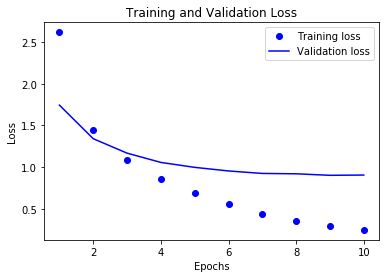

In [58]:
import matplotlib.pyplot as plt

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(loss)+1)

# training loss blue dotted
plt.plot(epochs, loss, "bo", label="Training loss")
# validation loss blue solid
plt.plot(epochs, val_loss, "b", label="Validation loss")
# title, labels, legend
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

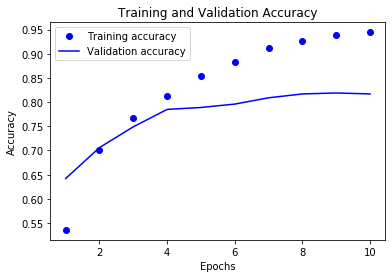

In [59]:
plt. clf()

acc = history.history["categorical_accuracy"]
val_acc = history.history["val_categorical_accuracy"]

# training accuracy blue dotted
plt.plot(epochs, acc, "bo", label="Training accuracy")
# validation accuracy blue solid
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
# title, labels, legend
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

### Evaluate Test Data

In [60]:
results = model.evaluate(x_test, one_hot_test_labels)
print(results)

2246/2246 [==============================] - 0s 135us/step
[0.9861285242775351, 0.7898486197684773]


#### Generate Predictions on New Data

In [62]:
predictions = model.predict(x_test)

random_pick = np.random.randint(0, len(x_test)-1)
print("looking at entry: {}".format(random_pick))
print("Shape: {}".format(predictions[random_pick].shape))
print("Largest entry (predicted class): {}".format(np.argmax(predictions[random_pick])))


looking at entry: 804
Shape: (46,)
Largest entry (predicted class): 36
